### Project Title : - Using Lung ultrasound images for building a reliable Point-of-care Covid-19 testing system

#### Binary Classifier : For classifying lung ultrasound images into one of the two categories : Covid and Non Covid

In [ ]:
# mounting the google drive

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#Changing the current working directory
cd drive/MyDrive/

/content/drive/MyDrive


#### Splitting the dataset into training, testing and validation

In [ ]:
#Installing the library split-folders
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

#Splitting the entire dataset into training, testing and validation folders with 70%,20% and 10% percentages of the dataset respectively

splitfolders.ratio('/content/drive/MyDrive/My_Dataset',output ='binary_two', ratio = (.7,0.1,0.2))

Copying files: 13846 files [03:30, 65.91 files/s]


#### Dataset Loading and Pre-processing

In [ ]:
#Importing the necessary libraries

import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Creating path for dataset folders
p = Path().cwd()
q = p/'binary_two'

#Images would be fed into the model as a batch of this size
batch_size = 512

#Rescaling the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


#Creating data generators for all the three datasets

train_generator = train_datagen.flow_from_directory(q/'train',target_size=(197,198), batch_size= batch_size,class_mode ='categorical', shuffle = False)

test_generator = test_datagen.flow_from_directory(q/'test',target_size= (197,198), batch_size= batch_size,class_mode ='categorical', shuffle = False)

val_generator = val_datagen.flow_from_directory(q/'val',target_size=(197,198), batch_size= batch_size,class_mode ='categorical', shuffle = False)

        # confirm the iterator works

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 9691 images belonging to 2 classes.
Found 2771 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.
Batch shape=(512, 197, 198, 3), min=0.000, max=1.000


#### Calculating weights for each class

In [ ]:
from sklearn.utils import class_weight
import numpy as np

#Picking up the classes available in training data

train_classes = train_generator.classes[train_generator.index_array]

#Computing weight for each class keeping them balanced 

#The minority class i.e. Covid is expected to be given a greater weight than the majority class Non-Covid to make these two balanced

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )

#Th dictionary contains weights for both classes

class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights


{0: 1.7115860120098905, 1: 0.7063411078717201}

#### Pretrained model - ResNet50V2

In [ ]:
#getting the feature extractor part of the model

pretrained= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(197,198, 3), weights='imagenet')

#Freezing all of its layers as we wish to retain it's parameters

pretrained.trainable=False


94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
#Model's classifier part

inputs = tf.keras.Input(shape=(197,198,3))
x = pretrained(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

resnet = tf.keras.Model(inputs, outputs)

#Getting the model architecture
resnet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 197, 198, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 74,946,562
Trainable params: 51,381,762
Non-tra

In [ ]:
#Compiling the model with the appropriate parameters

resnet.compile(loss="categorical_crossentropy",optimizer = 'rmsprop', metrics=["accuracy"])

#We wish to track the validation loss and save the best model

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath="n.keras",
                                            save_best_only=True,
                                            monitor="val_loss")


In [ ]:
#Training the model, the class weight parameter has been set up to the computed weights 

network_2 = resnet.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 3 , validation_data= val_generator,
             validation_steps = len(val_generator), callbacks = [callbacks], class_weight = class_weights)

Epoch 1/3
19/19 [==============================] - 1621s 87s/step - loss: 302.2700 - accuracy: 0.6999 - val_loss: 41.4349 - val_accuracy: 0.8960
Epoch 2/3
19/19 [==============================] - 85s 4s/step - loss: 64.1309 - accuracy: 0.8361 - val_loss: 8.9405 - val_accuracy: 0.9639
Epoch 3/3
19/19 [==============================] - 85s 5s/step - loss: 53.7443 - accuracy: 0.8746 - val_loss: 5.5164 - val_accuracy: 0.9342


#### Generating predictions

In [ ]:
import numpy as np

#The model is now being used for making predictions on the test dataset
predict = resnet.predict_generator(
    test_generator, workers=0, verbose=0
)

#Getting class of the predictions made
predictedClass = np.argmax(predict, axis=1)

#True class of every image in test data
trueClass = test_generator.classes[test_generator.index_array]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

#Computing the performance metrics
print("Precision score is ", precision_score(trueClass, predictedClass))
print("Accuracy score is ", accuracy_score(trueClass, predictedClass))
print("Recall is ",recall_score(trueClass, predictedClass))
print("F1 score is ",f1_score(trueClass, predictedClass))

Precision score is  0.9994356659142212
Accuracy score is  0.9310718152291592
Recall is  0.903110657827639
F1 score is  0.948834717385481


In [ ]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

#Confusion matrix prints out predictions per class 
confusionMatrix = (confusion_matrix(
        y_true = trueClass,                                       
        y_pred = predictedClass))                                

print(confusionMatrix)

[[ 809    1]
 [ 190 1771]]


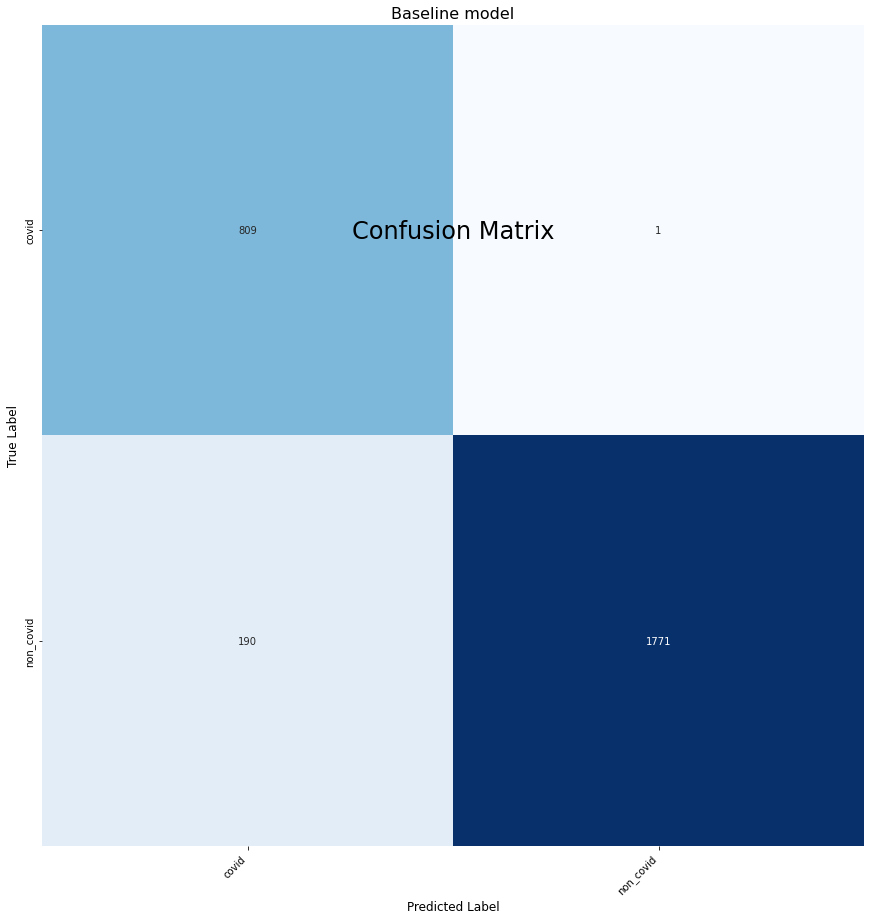

In [ ]:
#Visualizing the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

true_classes = test_generator.classes

class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(trueClass, predictedClass, class_names, ax1, title="Baseline model")    

fig.suptitle("Confusion Matrix", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()